In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/amazon_cells_labelled.txt
/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/imdb_labelled.txt
/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/readme.txt
/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/yelp_labelled.txt


In [3]:
amazon = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/amazon_cells_labelled.txt', 
                     sep='\t',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
imdb = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/imdb_labelled.txt', 
                     sep='\t|\s{3}',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
yelp = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/yelp_labelled.txt', 
                     sep='\t',
                     lineterminator='\n',
                     names=['sentance', 'sentiment'] )
print(f"amazon = {amazon.shape}, imdb = {imdb.shape}, yelp = {yelp.shape}")

amazon = (1000, 2), imdb = (1000, 2), yelp = (1000, 2)


/tmp/ipykernel_24/3939053422.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imdb = pd.read_csv('/kaggle/input/sentiment-labelled-sentences/sentiment labelled sentences/imdb_labelled.txt',


In [4]:
data = pd.DataFrame(data=np.concatenate([amazon,imdb,yelp], axis=0), columns=['sentance', 'sentiment'])
data.shape

(3000, 2)

In [5]:
data

,sentance,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2995,I think food should have flavor and texture an...,0
2996,Appetite instantly gone.,0
2997,Overall I was not impressed and would not go b...,0
2998,"The whole experience was underwhelming, and I ...",0


In [6]:
import string

def remove_punc(sentance):
    return sentance.translate(str.maketrans('','',string.punctuation))

print(remove_punc('What? Where did all the punctuation go????'))

What Where did all the punctuation go


In [7]:
!pip install pyspellchecker

from spellchecker import SpellChecker

sc = SpellChecker()

def correct(sentance):
    misspelled = sc.unknown(str(sentance).split())
    correct = [sc.correction(w) if w in misspelled else w for w in sentance.split()]
    return " ".join(filter(lambda c : c is not None, correct))

print(correct('its spellinf timr'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.3 MB/s eta 0:00:00
its spelling time


In [8]:
from nltk.corpus import stopwords

def remove_stop(sentance):
    correct = [w for w in sentance.split() if w not in stopwords.words('english')]
    return " ".join(correct)

print(remove_stop('There are no longer stop words, so why even bother.'))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


There longer stop words, even bother.


In [9]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def stemming(sentance):
    correct = [stemmer.stem(w) for w in sentance.split()]
    return " ".join(correct)

print(stemming('It is finally time for some good old stemming shenanigans'))

It is final time for some good old stem shenanigan


In [10]:
def remove_numbers(sentance):
    return " ".join([s for s in sentance.split() if not s.isdigit()])

print(remove_numbers('There were at least 10 numbers here, but 0 are left'))

There were at least numbers here, but are left


In [11]:
def prepare_data(sentance, vectorizer=None):
    sentance = sentance.lower()
    sentance = remove_punc(sentance)
    sentance = correct(sentance)
    sentance = remove_stop(sentance)
    sentance = stemming(sentance)
    sentance = remove_numbers(sentance)
    if vectorizer is None:
        return sentance
    else: 
        return np.asarray(vectorizer(sentance).numpy(), dtype='float32').reshape(1,-1)

In [12]:
x = data['sentance']
y = data['sentiment']
x

0       So there is no way for me to plug it in here i...
1                             Good case, Excellent value.
2                                  Great for the jawbone.
3       Tied to charger for conversations lasting more...
4                                       The mic is great.
                              ...                        
2995    I think food should have flavor and texture an...
2996                             Appetite instantly gone.
2997    Overall I was not impressed and would not go b...
2998    The whole experience was underwhelming, and I ...
2999    Then, as if I hadn't wasted enough of my life ...
Name: sentance, Length: 3000, dtype: object

In [13]:
x = x.map(lambda x : prepare_data(x))

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1234)

In [15]:
from keras.layers import TextVectorization
import tensorflow as tf
data_to_adapt = tf.constant(x_train)

n = 7

vectorizer = TextVectorization(output_mode='tf-idf', ngrams=n)
vectorizer.adapt(data_to_adapt)

In [16]:
vectorizer(x[0]).numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [17]:
x_train = x_train.map(lambda x : vectorizer(x).numpy())
x_test = x_test.map(lambda x : vectorizer(x).numpy())

x_train = np.asarray([x.astype('float32') for x in x_train])
x_test = np.asarray([x.astype('float32') for x in x_test])

y_train = np.asarray(y_train, dtype='float32')
y_test = np.asarray(y_test, dtype='float32')

In [18]:
from keras.models import load_model
#model = load_model('/kaggle/working/sentiment_model.h5')

In [19]:
from keras.layers import Input, Dropout, Dense, Activation, BatchNormalization
from keras import Model
from keras.utils import plot_model
from keras.regularizers import L2


def make_model(input_size):
    latent = [1024, 512, 128, 64]

    inputs = Input(shape=(input_size, ))
    layer = inputs

    for l in latent:
        layer = Dense(l, 
                      activation='relu', 
                      kernel_regularizer=L2(1e-4), 
                      bias_regularizer=L2(1e-4))(layer)
    
        layer = BatchNormalization()(layer)
        layer = Dropout(0.4)(layer)

    outputs = Dense(1, activation='sigmoid')(layer)

    model = Model(inputs, outputs)
    return model

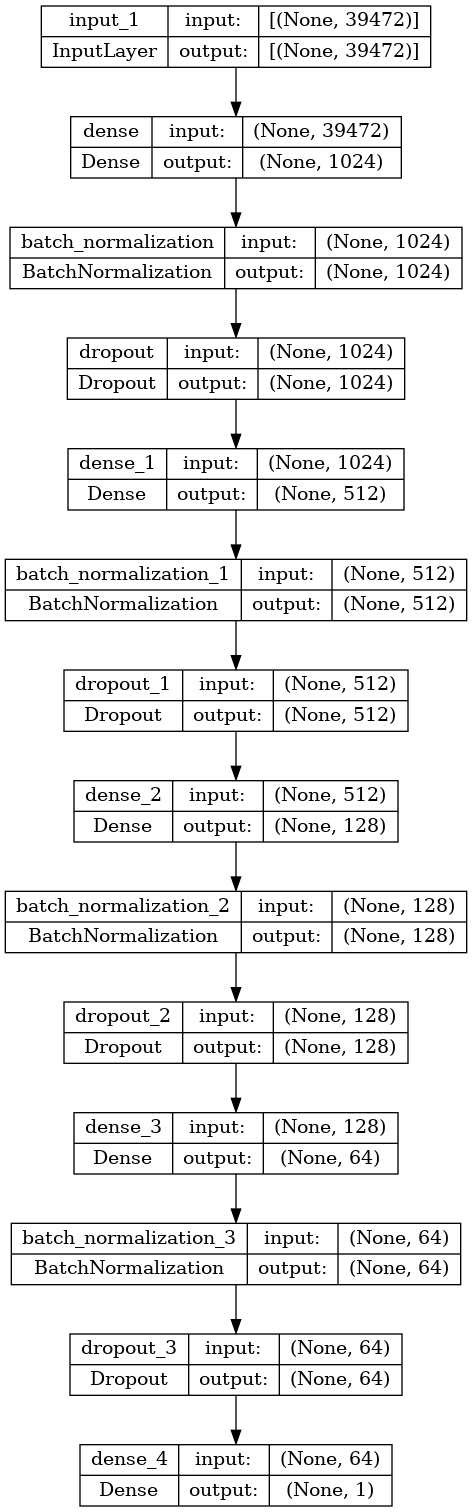

In [20]:
model = make_model(vectorizer.vocabulary_size())
plot_model(model, show_shapes=True)

In [21]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=10)

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, 
                    validation_split=0.2, 
                    epochs=50, batch_size=64, 
                    callbacks=[callback])

Epoch 1/50
27/27 [==============================] - 7s 44ms/step - loss: 1.2118 - accuracy: 0.6554 - val_loss: 2.5738 - val_accuracy: 0.7524
Epoch 2/50
27/27 [==============================] - 1s 23ms/step - loss: 3.0145 - accuracy: 0.8399 - val_loss: 2.9985 - val_accuracy: 0.7952
Epoch 3/50
27/27 [==============================] - 1s 23ms/step - loss: 2.5280 - accuracy: 0.9220 - val_loss: 2.2975 - val_accuracy: 0.7762
Epoch 4/50
27/27 [==============================] - 1s 23ms/step - loss: 1.9157 - accuracy: 0.9488 - val_loss: 1.8725 - val_accuracy: 0.7786
Epoch 5/50
27/27 [==============================] - 1s 23ms/step - loss: 1.6552 - accuracy: 0.9530 - val_loss: 1.6955 - val_accuracy: 0.7714
Epoch 6/50
27/27 [==============================] - 1s 23ms/step - loss: 1.5573 - accuracy: 0.9381 - val_loss: 1.7069 - val_accuracy: 0.7571
Epoch 7/50
27/27 [==============================] - 1s 24ms/step - loss: 1.5748 - accuracy: 0.9131 - val_loss: 1.6680 - val_accuracy: 0.7714
Epoch 8/50
27

In [22]:
model.evaluate(x_test, y_test)

29/29 [==============================] - 0s 5ms/step - loss: 1.7248 - accuracy: 0.7611


[1.7248414754867554, 0.7611111402511597]

In [23]:
dict = {0 : 'negative', 1 : 'positive'}

def predict_sentiment(sentance, vectorizer, model):
    prediction = np.round(model.predict(prepare_data(sentance, vectorizer)))
    return dict.get(prediction.item())

In [24]:
predict_sentiment('Good enough', vectorizer, model)

1/1 [==============================] - 0s 158ms/step


'negative'

In [25]:
model.save('/kaggle/working/sentiment_model.h5')

In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc.score(x_test, y_test)

0.7344444444444445

In [27]:
predict_sentiment('Wow, such a nice product!', vectorizer, rfc)

'positive'

In [28]:
from sklearn.feature_selection import SelectPercentile, chi2


sp = SelectPercentile(chi2, percentile=5)
x_train = sp.fit_transform(x_train, y_train)

x_test = sp.transform(x_test)

rfc2 = RandomForestClassifier()

In [29]:
rfc2.fit(x_train, y_train)
rfc2.score(x_test, y_test)

0.7722222222222223

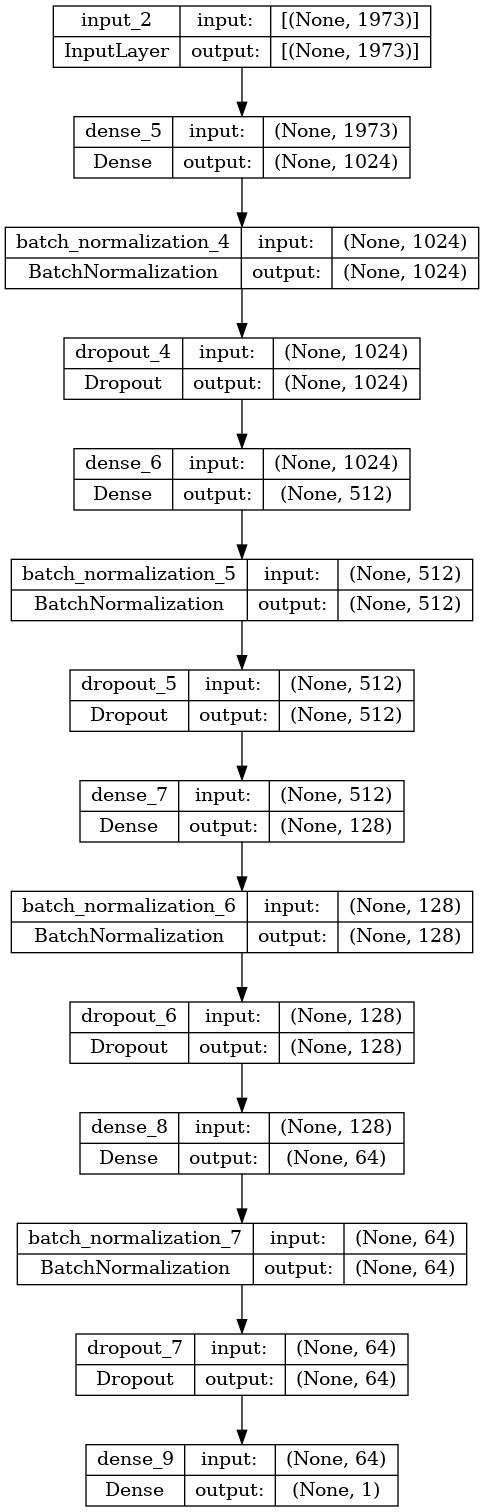

In [30]:
model2 = make_model(x_train.shape[1])
plot_model(model2, show_shapes=True)

In [31]:
model2.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['accuracy'])
history = model2.fit(x=x_train, y=y_train, 
                    validation_split=0.2, 
                    epochs=50, batch_size=64, 
                    callbacks=[callback])

Epoch 1/50
27/27 [==============================] - 2s 18ms/step - loss: 0.5055 - accuracy: 0.7089 - val_loss: 0.6249 - val_accuracy: 0.8143
Epoch 2/50
27/27 [==============================] - 0s 8ms/step - loss: 0.6129 - accuracy: 0.8768 - val_loss: 0.6504 - val_accuracy: 0.8333
Epoch 3/50
27/27 [==============================] - 0s 8ms/step - loss: 0.5486 - accuracy: 0.9149 - val_loss: 0.5626 - val_accuracy: 0.8429
Epoch 4/50
27/27 [==============================] - 0s 8ms/step - loss: 0.4581 - accuracy: 0.9185 - val_loss: 0.4895 - val_accuracy: 0.8357
Epoch 5/50
27/27 [==============================] - 0s 9ms/step - loss: 0.4028 - accuracy: 0.9107 - val_loss: 0.4408 - val_accuracy: 0.8286
Epoch 6/50
27/27 [==============================] - 0s 8ms/step - loss: 0.3665 - accuracy: 0.9119 - val_loss: 0.4226 - val_accuracy: 0.8262
Epoch 7/50
27/27 [==============================] - 0s 9ms/step - loss: 0.3558 - accuracy: 0.9018 - val_loss: 0.4211 - val_accuracy: 0.8214
Epoch 8/50
27/27 [=

In [32]:
model2.evaluate(x_test, y_test)

29/29 [==============================] - 0s 3ms/step - loss: 0.4201 - accuracy: 0.7467


[0.42012178897857666, 0.746666669845581]